Implementing a toy simulation for Bayesian A/B test with continuously distributed success metric on a mixed model that depends on a binary bootleneck.  

Context:  
- user-level randomization
- two groups
- imbalanced weights
- same user can have repeated measurements
- multiple aggregation levels
  - many reads a day
  - daily aggregation
  - cumulative aggregation over period

Examples of practical business metrics that match the case:
- revenue / user
- transactions / user (approx. as we know transactions follow a discrete distribution)

From brainstorm with LLM:  

# Suitable Modeling Approaches:
Because the metric involves a mix of discrete (conversion) and continuous (transaction value) components, you should consider a two-part model to account for these different aspects.

## 1. Zero-Inflated or Hurdle Models

Since not all users make purchases, there are many zero-revenue users, and you need to account for this excess of zeros. Two popular approaches to handle this are zero-inflated models or hurdle models.

### Zero-Inflated Model: 

This model assumes that users come from two latent groups — those who will never make a purchase and those who may or may not make a purchase, based on some probability. In this case, the revenue per user is modeled as:

$$
P(\text{Revenue per User}=0)=(\text{Probability of no purchase group}) + (\text{Probability of purchase group but no purchase})
$$

The second group, if they do make a purchase, follows a continuous distribution for the transaction value.

### Hurdle Model:  
This model assumes that all zeros come from users who do not convert (i.e., they do not "pass the hurdle" of making a purchase), and once users convert, their transaction values follow a continuous distribution (e.g., Gamma or Log-Normal). The hurdle is passed with some probability, and the distribution of revenue applies only to users who have converted.

## Log-Normal or Gamma for Transaction Value (Non-Zero Revenue)

For users who make a purchase, the transaction value (revenue per user) is continuous, positive, and unbounded, but skewed (with some users potentially making very large purchases). Two common distributions for modeling such data are:

### Log-Normal Distribution:  

This is a good candidate when the revenue is positively skewed and the log of the transaction value is normally distributed.  
The Log-Normal distribution handles unbounded positive data and allows for long tails, which could accommodate a few users making very large purchases.

$$
\text{Revenue} \sim \log-\text{Normal}(\mu,\sigma^2)
$$

### Gamma Distribution: 
The Gamma distribution is another suitable choice for modeling positive, continuous data, especially when the data is skewed.  
Like the Log-Normal, the Gamma distribution handles unbounded positive data and can be parameterized with a shape and rate (or scale) parameter.

$$
\text{Revenue} \sim \text{Gamma}(\alpha, \beta)
$$

## Two-Part Model (Combining Discrete and Continuous Parts)
A two-part model combines the discrete conversion probability and the continuous transaction value for those who convert. For example:  

### Part 1: Conversion Probability: 
You can model the probability of conversion (purchase) using a Bernoulli or Logistic Regression model, which would predict whether a user converts or not:

$$
\text{Conversion}\sim \text{Bernoulli}(p)
$$

Here, $p$ is the probability that a user makes a purchase.  

### Part 2: Transaction Value:   

For users who do convert, model the non-zero transaction value using either a Gamma or Log-Normal distribution, as discussed above.  
The overall likelihood can then be constructed as a combination of these two parts:

$$
P(\text{Revenue per user}) = P(\text{conversion}) \times P(\text{Transaction Value} | \text{Conversion})
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Data Generating Process

Just a toy example with ideally Gaussian distributed before we go into a more structured dataset.  
Let's ignore the daily grains for a moment and assume a single observation per randomization unit.  

We're going to use a two-part likelihood model for the revenue per user:  
$$
P(\text{Revenue per user}) = P(\text{conversion}) \times P(\text{Transaction Value} | \text{Conversion})
$$

In order to contribute to revenue per user, a user has to first convert (decide to pay), which is a binary process explained by $P(\text{conversion})$.  
As we can see, once users decided to pay, their transaction value is sampled from $P(\text{Transaction Value} | \text{Conversion})$.  
If we'd sample transaction value from the total population (converted and not-converted users), a big mass of users would inflate the distribution `@ transaction value = 0`.  

Some definitions:  

Dataset $\cal{D}=\lbrace y_i, t_i \rbrace$ $\forall i=1, \ldots, N$ is the observed data (evidence, variables of the likelihood function):
- $y_i \in \lbrace 0, 1 \rbrace$: represents weather user $i$ converted ($y_i=1$) or not ($y_i=0$)  
- $t_i \in \mathbb{R}$ (or maybe $\mathbb{R}^+$ would make more sense if we want to ignore negative income e.g. refunds, free/discounted items, etc.)  

Random variables, whose distributions are defined by the parameters we wish to estimate and its priors assumptions:  
- $p$: is the probability of conversion, 
  - it follows a prior $p \sim \text{Beta}(\alpha_p ,\beta_p)$ 
  - we have to estimate both $\alpha_p$ and $\beta_p$    
- $T$ is the transaction value for converters
  - assumed to follow a continuous distribution, say $T \sim \text{Gamma}(\alpha_T ,\beta_T)$, 
  - where $\alpha_T$ and $\beta_T$ are the shape and rate parameters, respectively, **with their own priors**

Let's break it down for both $\alpha_T$ (shape) and $\beta_T$ (rate), and we'll explore how to set the parameters $a_T$, $b_T$ (for $\alpha_T$) and $c_T$, $d_T$ (for $\beta_T$).

## 1. Setting Priors for $\alpha_T$ (Shape Parameter)
The shape parameter $\alpha_T$ in a Gamma distribution affects the skewness and the behavior of the distribution:

- If $\alpha_T > 1$, the Gamma distribution is unimodal and more symmetrical.
- If $\alpha_T=1$, the Gamma distribution becomes an exponential distribution.
- If $\alpha_T<1$, the Gamma distribution is highly skewed.

The goal is to set a Gamma prior on $\alpha_T$ with parameters $a_T$ and $b_T$.

### Choice of $a_T$ and $b_T$ (Gamma Prior for $\alpha_T$):

- **Non-informative Prior**: A Gamma(1, 1) prior on 𝛼ₜ would serve as a common non-informative prior, allowing 𝛼ₜ to vary freely while being positive. This prior reflects a weak belief that 𝛼ₜ is around 1 (exponential), but allows for a wide range of possible values.
- **Weakly Informative Prior**: If you want a more diffuse prior, you can choose Gamma(0.001, 0.001) to make it almost flat, which is commonly used when we want the prior to have little influence. This means that 𝛼ₜ can take any positive value, with very weak prior information.

## 2. Setting Priors for $\beta_T$ (Rate Parameter)
The rate parameter $\beta_T$ (inverse of the scale) in the Gamma distribution determines how spread out the distribution is:

- Smaller values of $\beta_T$ correspond to more spread (larger expected transaction values).
- Larger values of $\beta_T$ correspond to tighter distributions around smaller values.

You want a Gamma prior on $\beta_T$ with parameters $c_T$ and $d_T$.

### Choice of $c_T$ and $d_T$ (Gamma Prior for $\beta_T$):
- **Non-informative Prior**: A Gamma(1, 1) prior on $\beta_T$ would act as a non-informative prior, implying that you have little information about the rate, but expect it to be around 1. This choice means that the prior is centered around 1, but allows for a wide range of possible rate values.
- **Weakly Informative Prior**: If you want the prior to be even less informative, Gamma(0.001, 0.001) can be used, meaning you have almost no prior information about $\beta_T$, allowing it to be highly uncertain.

## Summary of Priors for $\alpha_T$ and $\beta_T$:
- **For $\alpha_T$ (shape of the Gamma distribution for transaction values):**
  - Non-informative prior: Gamma(1, 1)
  - Weakly informative prior: Gamma(0.001, 0.001)
  
- **For $\beta_T$ (rate of the Gamma distribution for transaction values):**
  - Non-informative prior: Gamma(1, 1)
  - Weakly informative prior: Gamma(0.001, 0.001)


## Posterior Distribution Derivation

Let's derive the posterior distribution.  
We have defined our priors above, and our likelihood format.  
Assumptions (typical) we'll make are:
- joint users distribution can be broken into a product of independent user-level distributions (i.i.d. samples)
- priors joint is also broken with independency assumption
- we'll ignore $P(\mathcal{D})$ denominator as it is a constant value independent of the parameters in the posterior equation

### Likelihood function:

$$P(\text{Revenue per User}) = P(y_i = 1 ∣ p) P(t_i ∣ y_i =1, \alpha_T , \beta_T )$$

- if user does not convert, i.e $y_i=0$
$$P(\text{Revenue per User} | y_i=0) = P(y_i = 0 ∣ p) = 1 -p $$

- if user converts, i.e. $y_i=1$
  - The probability of conversion $p$.
  - The likelihood of the observed transaction value given the parameters of the Gamma distribution.

$$P(\text{Revenue per User} | y_i=1) = p \times \text{Gamma}(t_i | \alpha_T, \beta_T) = p \dfrac{\beta_T ^ {\alpha_T}}{\Gamma(\alpha_T)} t_i^{\alpha_T-1}\exp{(-\beta_T t_i)}$$

Thus the overall likelihood will be:
$$
P(\mathcal{D} | p, \alpha_T, \beta_T) = \prod_{i=1}^{N} \left[ (1-p)^{1-y_i} \times \left(  p \dfrac{\beta_T ^ {\alpha_T}}{\Gamma(\alpha_T)} t_i^{\alpha_T-1}\exp{(-\beta_T t_i)} \right)^{y_i} \right]
$$

### Prior Equations

As we've defined the priors before, let's just expand their distribution density equations here:

For conversion probability $p$, we place a Beta prior: $\text{Beta}(\alpha_p ,\beta_p)$:
$$
P(p)= \dfrac{p^{\alpha_p - 1} (1-p)^{\beta_p-1}}{B(\alpha_p, \beta_p)}
$$

For transaction value parameters, we place priors on $\alpha_T$ and $\beta_T$.  
For simplicity, **we assume independent Gamma priors**:
- $\alpha_T \sim \text{Gamma}(a_T, b_T)$
- $\beta_T \sim \text{Gamma}(c_T, d_T)$  

where $p(x; \alpha, \beta)$ for a Gamma distribution is given by:
$$
p(x) = \dfrac{\beta ^ \alpha}{\Gamma(\alpha)}x^{\alpha-1}\exp{(-\beta x)}
$$

### Posterior Equation

$$
P(p, \alpha_T, \beta_T | \mathcal{D} )  = \dfrac{P(\mathcal{D} | p, \alpha_T, \beta_T) \times P(p, \alpha_T, \beta_T) }{P(\mathcal{D}) }
$$

$$
P(p, \alpha_T, \beta_T | \mathcal{D} )  \propto P(\mathcal{D} | p, \alpha_T, \beta_T) \times P(p) \times P(\alpha_T) \times P(\beta_T) 
$$

$$
P(p, \alpha_T, \beta_T | \mathcal{D} )  \propto  \\
\prod_{i=1}^{N} \left[ (1-p)^{1-y_i} \times \left(  p \dfrac{\beta_T ^ {\alpha_T}}{\Gamma(\alpha_T)} t_i^{\alpha_T-1}\exp{(-\beta_T t_i)} \right)^{y_i} \right]  \\
\times 
p^{\alpha_p - 1} (1-p)^{\beta_p - 1} \\
\times
\alpha_T^{a_T-1}\exp{(-b_T \alpha_T)} \\
\times
\beta_T^{c_T-1}\exp{(-d_T \beta_T)} 
$$

where scaling parts of the priors $\dfrac{1}{B(\alpha_p, \beta_p)}, \dfrac{b_T^{a_T}}{\Gamma(a_T)}, \dfrac{d_T^{c_T}}{\Gamma(c_T)}$ have also been removed since they are constants w.r.t. the posterior parameters $p, \alpha_T, \beta_T$.  




### Log-posterior

Maximizing the posterior in Bayesian estimation is equivalent to maximizing the logarithm of the posterior.  
This is because the logarithm is a monotonically increasing function, meaning that the values that maximize the posterior probability will also maximize its logarithm.  
There are benefits in writing the posterior in log form, both for numerical stability as well as for simplification of the products into sums that my put in evidence useful statistics from the data variables.  

Taking the log on the above equation of the posterior leads to:

$$
\log P(p, \alpha_T, \beta_T \mid D) \propto 
\sum_{i=1}^{N} \left[ (1 - y_i) \log(1 - p) + y_i \left( \log(p) + \alpha_T \log(\beta_T) - \log(\Gamma(\alpha_T)) + (\alpha_T - 1) \log(t_i) - \beta_T t_i \right) \right] \\
+ (\alpha_p - 1) \log(p) + (\beta_p - 1) \log(1 - p) \\
+ (a_T - 1) \log(\alpha_T) - b_T \alpha_T \\
+ (c_T - 1) \log(\beta_T) - d_T \beta_T.

$$

Let's define the following term that depend only on statistics of the dataset $\mathcal{D}$:
- $n_s=\sum_{i=1}^{N} y_i$ (num of converted users)
- $n_f= N - n_s$ (num of unconverted users)
- $H(y,t)=\sum_{i=1}^{N} y_i \log(t_i)$
- $R(y,t)=\sum_{i=1}^{N} y_i t_i$

Further simplification leads to:

$$
\log P(p, \alpha_T, \beta_T \mid D = \{y_i, t_i\}) \propto
$$

$$
\log(p) \cdot (n_s + \alpha_p - 1) + \log(1 - p) \cdot (n_f + \beta_p - 1)
$$

$$
+ \alpha_T \cdot \left( H(y,t) - b_T \right) + \log(\alpha_T) \cdot (a_T - 1) - \log(\Gamma(\alpha_T)) \cdot n_s
$$

$$
+ \beta_T \cdot \left( d_T + R(y,t) \right) + \log(\beta_T) \cdot (c_T - 1)
$$  

$$
+ \alpha_T \log(\beta_T) \cdot n_s
$$

where a constant term $-H(y,t)$ has been discarded as it is constant w.r.t. to posterior density variables.  
Also remark terms have been rearranged to follow the order of:
- $p$-dependent terms
- $\alpha_T$-dependent terms
- $\beta_T$-dependent terms
- cross-dependency between $\alpha_T$ and $\beta_T$ terms

# Synthetic data

To understand if our models work, we need synthetic data with known true parameters.  
Below we define some of them and auxiliar functions to connect them with mean values of a source distribution.  
This is necessary as we normally start from business metric statistics (e.g. avg. user conversion rates, avg. ticket value, as well as its dispersion statistics) and we will want to reproduce these in the synthetic data generation models we'll build.  

In [2]:
# auxiliar functions
def conversion_params_given_true_p(true_p, num_samples=2, alpha_0=1, beta_0=1):
    """Returns the alpha and beta parameters of a Beta distribution given the true conversion probability.  
    Num_samples proxies a precision of the beta distribution (alpha + beta).
    alpha_0 and beta_0 are the prior parameters of the Beta distribution.
    """
    num_success = num_samples * true_p
    num_fails = num_samples - num_success
    
    alpha = num_success + alpha_0
    beta = num_fails + beta_0

    return alpha, beta

def transaction_parameters_given_average_ticket_value(atv, std):
    """Returns the shape and rate parameters of a Gamma distribution given known values for average ticket value and its standard deviation (spread)."""
    
    # just rewriting parameters to be explicit with dependencies on ratio among location / dispersion statistics
    coeff_of_var = std / atv
    dispersion_index = (std ** 2) / atv

    # these come from the relationship between the mean and variance of a Gamma distribution
    alpha = 1 / (coeff_of_var ** 2)
    beta = 1 / dispersion_index
    return alpha, beta

def users_probability_conversion(alpha_p, beta_p, num_users):
    """Samples the conversion probability for each user from a Beta distribution."""
    p = np.random.beta(alpha_p, beta_p, size=num_users)
    return p

def users_conversion_status(p):
    """Simulates the conversion status (0 or 1) for each user based on the conversion probability."""
    conversions = np.random.binomial(1, p, size=len(p))
    return conversions

def users_transaction_values(alpha_t, beta_t, num_users):
    """Assuming every user converted, samples transaction values from a Gamma distribution."""
    transaction_values = np.random.gamma(alpha_t, 1 / beta_t, size=num_users)
    return transaction_values

def simulate_user_data(true_prob_user_converting, atv, std, num_users, seed=0):
    # Set seed for reproducibility
    np.random.seed(seed)
    
    # Calculate the parameters of the Beta distribution for conversion probability
    alpha_p, beta_p = conversion_params_given_true_p(true_prob_user_converting, num_users)
    
    # Calculate the parameters of the Gamma distribution for transaction values
    alpha_t, beta_t = transaction_parameters_given_average_ticket_value(atv, std)
    
    # Simulate user conversions
    p = users_probability_conversion(alpha_p, beta_p, num_users)
    conversions = users_conversion_status(p)
    
    # Simulate transaction values for converting users
    transaction_values = users_transaction_values(alpha_t, beta_t, num_users)
    
    # review this part! our posterior accounts for including ti only when yi=0 already
    # nulls for non-converting users
    # transaction_values[conversions == 0] = 0 
    
    return conversions, transaction_values

In [3]:
# hyperparameters
num_users = 10000

# conversion rate true parameters
true_prob_user_converting = 0.1
true_alpha_p, true_beta_p = conversion_params_given_true_p(true_prob_user_converting, num_users, alpha_0=1, beta_0=1)

print(f"True conversion rate: {true_prob_user_converting:.2%}")
print(f"Calculated Beta parameters -> alpha_p: {true_alpha_p:.2f}, beta_p: {true_beta_p:.2f}")

# transaction value true parameters
true_atv = 10  # average ticket value (atv)
true_txs_std = 20 # spread (std) of revenue/transaction; normally large spread due to long tail of revenue distribution
true_alpha_T, true_beta_T = transaction_parameters_given_average_ticket_value(true_atv, true_txs_std)

print(f"True average ticket value: {true_atv:.2f}, True std of transaction values per user: {true_txs_std:.2f}")
print(f"Calculated Gamma parameters -> alpha_T: {true_alpha_T:.2f}, beta_T: {true_beta_T:.2f}")


True conversion rate: 10.00%
Calculated Beta parameters -> alpha_p: 1001.00, beta_p: 9001.00
True average ticket value: 10.00, True std of transaction values per user: 20.00
Calculated Gamma parameters -> alpha_T: 0.25, beta_T: 0.03


## Generating toy example data and inspecting

In [4]:
# Simulate user conversions: conversion probabilities from the Beta distribution
p = users_probability_conversion(true_alpha_p, true_beta_p, num_users)

# Simulate whether each user converted or not (Bernoulli trial)
conversions = users_conversion_status(p)

# Simulate transaction values for converting users
transaction_values = users_transaction_values(true_alpha_T, true_beta_T, num_users)

# we actually only observe transaction values for converted users
transaction_values_observed = conversions * transaction_values

# Summary statistics
num_converted_users = np.sum(conversions)
total_revenue = np.sum(transaction_values_observed)

# Print summary
print(f"Number of users: {num_users}")
print(f"Number of converted users: {num_converted_users}")
print(f"Total revenue from converted users: ${total_revenue:.2f}")
print(f"Average revenue per user (RPU): ${total_revenue / num_users:.2f}")
print(f"Average revenue per converted user: ${total_revenue / num_converted_users:.2f}")

Number of users: 10000
Number of converted users: 1015
Total revenue from converted users: $11472.89
Average revenue per user (RPU): $1.15
Average revenue per converted user: $11.30


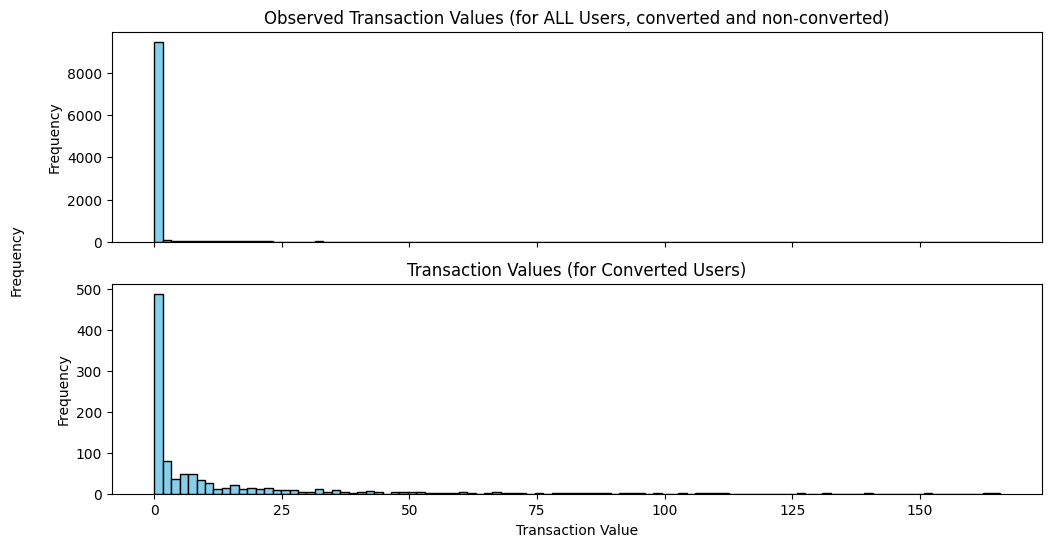

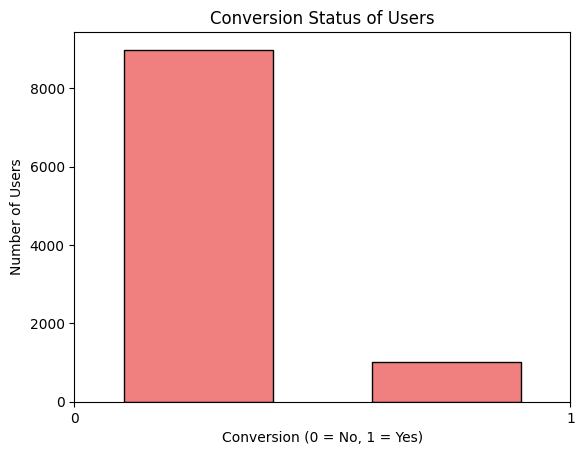

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Visualize the distribution of transaction values for all users
ax[0].hist(transaction_values_observed, bins=100, color='skyblue', edgecolor='black')
ax[0].set_title("Observed Transaction Values (for ALL Users, converted and non-converted)")
ax[0].set_ylabel("Frequency")

# Visualize the distribution of transaction values for converting users
ax[1].hist(transaction_values[conversions > 0], bins=100, color='skyblue', edgecolor='black')
ax[1].set_title("Transaction Values (for Converted Users)")
ax[1].set_xlabel("Transaction Value")
ax[1].set_ylabel("Frequency")

# Set common y-axis label for both subplots
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

# Plot conversion histogram
plt.figure()
plt.hist(conversions, bins=2, color='lightcoral', edgecolor='black', rwidth=0.6)
plt.title("Conversion Status of Users")
plt.xlabel("Conversion (0 = No, 1 = Yes)")
plt.ylabel("Number of Users")
plt.xticks([0, 1])
plt.show()

## A/B test Data Generation

Before we generate the data, let's just set our prior constants for the following simulation.  

In [6]:
# priors for conversion probability
alpha_0_p = 1
beta_0_p = 1

# priors for transaction value
a0_T = 0.001
b0_T = 0.001
c0_T = 0.001
d0_T = 0.001

Now we generate two datasets, with weighted number of samples for some given split we're observing.  
Each group (let's name them control and treatment) has its own true business metrics avg. values which we'll use as reference to evaluate our estimators.    

In [7]:
# fix random seed 
seed = 123456

# tuple of parameters for each group: (true_prob_user_converting, true_atv, true_txs_std) 
params_per_group = {
    "A": (0.1, 10, 20),
    "B": (0.12, 10, 20)
}

# test splits hyperparameters
num_total_users = 100000
weight_control = 0.5
weight_treatment = 1 - weight_control

num_users_control = int(num_total_users * weight_control)
num_users_treatment = num_total_users - num_users_control

# datasets
conversions_control, transaction_values_control = simulate_user_data(*params_per_group["A"], num_users_control, seed=seed)
conversions_treatment, transaction_values_treatment = simulate_user_data(*params_per_group["B"], num_users_treatment, seed=seed + 1)


# transform into pandas DataFrame for convenience
__GROUP_COL__ = "Group"
__CONVERSIONS_COL__ = "Conversions"
__TRANSACTION_VALUE_COL__ = "TransactionValue"
__TRANSACTION_CONVERTED_VALUE_COL__ = "TransactionConvertedValue"
__CONTROL_LABEL__ = "A"
__TREATMENT_LABEL__ = "B"

df = pd.DataFrame({
    __GROUP_COL__: [__CONTROL_LABEL__] * num_users_control + [__TREATMENT_LABEL__] * num_users_treatment,
    __CONVERSIONS_COL__: np.concatenate([conversions_control, conversions_treatment]),
    __TRANSACTION_VALUE_COL__: np.concatenate([transaction_values_control, transaction_values_treatment]), # this cannot be observed
    __TRANSACTION_CONVERTED_VALUE_COL__: np.concatenate([transaction_values_control * conversions_control, transaction_values_treatment * conversions_treatment])  # this is what is actually observed
})
df

,Group,Conversions,TransactionValue,TransactionConvertedValue
0,A,0,0.609606,0.0
1,A,0,11.168263,0.0
2,A,0,0.128395,0.0
3,A,0,22.577405,0.0
4,A,0,9.680209,0.0
...,...,...,...,...
99995,B,0,0.060682,0.0
99996,B,0,0.000971,0.0
99997,B,0,6.256679,0.0
99998,B,0,0.451106,0.0


Given a dataset like this, we can have data-drive point estimates per group.  

In [8]:
# point estimates of the likelihood of conversion and transaction per group
df.groupby(__GROUP_COL__).agg(['mean', 'std'])

Conversions           TransactionValue             \
             mean       std             mean        std   
Group                                                     
A         0.10024  0.300323        10.052293  20.206232   
B         0.12442  0.330063         9.984008  19.888507   

      TransactionConvertedValue            
                           mean       std  
Group                                      
A                      1.053095  7.364634  
B                      1.237952  7.890833

In [9]:
# sanity check on the observed transaction values
df.groupby(__GROUP_COL__).mean()[__CONVERSIONS_COL__] * df.groupby(__GROUP_COL__).mean()[__TRANSACTION_VALUE_COL__]

Group
A    1.007642
B    1.242210
dtype: float64

In [10]:
df[df[__CONVERSIONS_COL__] > 0].groupby(__GROUP_COL__).agg(['mean', 'std'])

Conversions      TransactionValue            TransactionConvertedValue  \
             mean  std             mean        std                      mean   
Group                                                                          
A             1.0  0.0        10.505733  21.020233                 10.505733   
B             1.0  0.0         9.949786  20.342558                  9.949786   

                  
             std  
Group             
A      21.020233  
B      20.342558

# Estimation Methods

Filtering the data for a single group now, and trying to estimate its parameters using the posterior equations derived in the first section.  


In [11]:
# Select the group to analyze
SELECTED_GROUP = __CONTROL_LABEL__ 
# SELECTED_GROUP = __TREATMENT_LABEL__

# Assuming df is your dataframe with the A/B test data
yi = df[df[__GROUP_COL__] == SELECTED_GROUP][__CONVERSIONS_COL__]
ti = df[df[__GROUP_COL__] == SELECTED_GROUP][__TRANSACTION_CONVERTED_VALUE_COL__]


## MAP estimator

An approach to find the set of parameters $p^\ast, {\alpha_T}^\ast, {\beta_T}^\ast$ that minimize $-\log{P(p, \alpha_T, \beta_T | \mathcal{D})}$.  

In [12]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln
import math

# TODO: fix this function
# I think there's something fundamentally wrong with this approach.  
# Although we're looking to estimate p, alpha_T and beta_T, they are random variables with their own distributions parametrized by alpha_p, beta_p, a_T, b_T, c_T, d_T.  
# So, we should be finding optimal values for alpha_p, beta_p, a_T, b_T, c_T, d_T, then computing the expected value of p, alpha_T and beta_T
# and finally plugging them into the likelihood function to get the likelihood of the observed data given the parameters.


def neg_log_posterior(params, yi, ti, epsilon=1e-12):
    """Negative log-posterior for the Bayesian model.
    Inputs:
    params (list): List of parameter values (alpha_p, beta_p, a_T, b_T, c_T, d_T)
    yi (array): Array of conversion status (0 or 1)
    ti (array): Array of transaction values (for converting users)
    epsilon (float): Small value to prevent log(0)
    Returns:
    float: Negative log-posterior value
    """
    # Unpack the parameters
    alpha_p, beta_p, a_T, b_T, c_T, d_T = params
    
    # Compute the expected values of p, alpha_T, and beta_T from the parameters
    p = alpha_p / (alpha_p + beta_p)
    alpha_T = a_T / b_T
    beta_T = c_T / d_T
    
    # Number of successes (sum of yi) and total number of observations
    n_s = yi.sum()
    N = len(yi)
    nf = N - n_s
    
    # Sum terms for ti where yi == 1, using epsilon to prevent log(0)
    H_yt = np.sum(yi * np.log(ti + epsilon))
    R_yt = np.sum(yi * ti)
    
    # Log-posterior for p (Bernoulli likelihood + Beta prior)
    log_p_term = np.log(p + epsilon) * (n_s + alpha_p - 1) + np.log(1 - p + epsilon) * (nf + beta_p - 1)
    
    # Log-posterior for alpha_T (Gamma prior)
    log_alpha_T_term = (
        alpha_T * (H_yt - b_T)
        + np.log(alpha_T + epsilon) * (a_T - 1)
        - n_s * gammaln(alpha_T)  # Use gammaln instead of math.gamma
    )
    
    # Log-posterior for beta_T (Gamma prior)
    log_beta_T_term = (
        beta_T * (d_T + R_yt)
        + np.log(beta_T + epsilon) * (c_T - 1)
    )
    
    # Cross-term between alpha_T and beta_T
    cross_term = alpha_T * np.log(beta_T + epsilon) * n_s
    
    # Total log-posterior (negated for minimization)
    log_posterior = log_p_term + log_alpha_T_term + log_beta_T_term + cross_term
    
    return -log_posterior  # Negate for minimization


In [21]:
# Initial guess for p based on observed conversion rate
initial_guess_p = yi.mean()  # Mean of conversions to initialize p

# Initial guess for transaction value based on observed data for converters (y_i = 1)
point_estimate_atv = ti[yi > 0].mean()  # Mean transaction value
std_estimate_atv = ti[yi > 0].std()  # Standard deviation of transaction value

print(f"Initial guess for p: {initial_guess_p:.2%}")
print(f"Initial guess for average transaction value: {point_estimate_atv:.4f}")
print(f"Initial guess for std of transaction value: {std_estimate_atv:.4f}")

# Convert initial guess for mean and standard deviation of transaction value
# into initial guesses for alpha_T and beta_T of the Gamma distribution
initial_guess_alpha_T, initial_guess_beta_T = transaction_parameters_given_average_ticket_value(
    point_estimate_atv, 
    std_estimate_atv
)

print(f"Initial guess for alpha_T: {initial_guess_alpha_T:.4f}")
print(f"Initial guess for beta_T: {initial_guess_beta_T:.4f}")

# Now we need to derive initial guesses for the hyperparameters of p, alpha_T, and beta_T

# Guess for the Beta distribution parameters for p (conversion probability)
# Given that p is the mean of a Beta distribution, we can initialize with:
initial_guess_alpha_p = initial_guess_p * 10  # Adjust based on prior confidence
initial_guess_beta_p = (1 - initial_guess_p) * 10

# Guess for the Gamma distribution parameters for alpha_T and beta_T
# Since alpha_T and beta_T come from Gamma distributions, use the current estimates
# to initialize the hyperparameters.
# Gamma distribution mean is alpha/beta, variance is alpha/beta^2
initial_guess_a_T = initial_guess_alpha_T  # Keep initial alpha_T as mean
initial_guess_b_T = 1  # Can adjust based on confidence level in alpha_T
initial_guess_c_T = initial_guess_beta_T  # Keep initial beta_T as mean
initial_guess_d_T = 1  # Can adjust based on confidence level in beta_T

# Combine all initial guesses for the hyperparameters into one vector
initial_guess = [
    initial_guess_alpha_p, initial_guess_beta_p,  # Beta distribution params for p
    initial_guess_a_T, initial_guess_b_T,         # Gamma distribution params for alpha_T
    initial_guess_c_T, initial_guess_d_T          # Gamma distribution params for beta_T
]

print(f"Initial guess for alpha_p: {initial_guess_alpha_p:.4f}")
print(f"Initial guess for beta_p: {initial_guess_beta_p:.4f}")
print(f"Initial guess for a_T (shape of alpha_T): {initial_guess_a_T:.4f}")
print(f"Initial guess for b_T (rate of alpha_T): {initial_guess_b_T:.4f}")
print(f"Initial guess for c_T (shape of beta_T): {initial_guess_c_T:.4f}")
print(f"Initial guess for d_T (rate of beta_T): {initial_guess_d_T:.4f}")

# Set bounds for the hyperparameters
min_alpha_p = 1  # Minimum for alpha_p (Beta distribution for p)
min_beta_p = 1   # Minimum for beta_p (Beta distribution for p)
min_a_T = min(initial_guess_a_T, initial_guess_b_T, initial_guess_c_T, initial_guess_d_T) / 1000 # Minimum for alpha_T (Gamma distribution for alpha_T)
min_b_T = min_a_T  # Minimum for b_T (Gamma distribution for alpha_T)
min_c_T = min_a_T # Minimum for c_T (Gamma distribution for beta_T)
min_d_T = min_a_T  # Minimum for d_T (Gamma distribution for beta_T)

max_alpha_p = len(yi)  # No upper bound for Beta hyperparameters
max_beta_p = len(yi)
max_a_T = max(initial_guess_a_T, initial_guess_b_T, initial_guess_c_T, initial_guess_d_T) * 1000  # Adjust based on initial guesses
max_b_T = max_a_T
max_c_T = max_a_T
max_d_T = max_a_T

# Define bounds for the optimization process
bounds = [
    (min_alpha_p, max_alpha_p), (min_beta_p, max_beta_p),  # Beta distribution bounds for p
    (min_a_T, max_a_T), (min_b_T, max_b_T),                # Gamma distribution bounds for alpha_T
    (min_c_T, max_c_T), (min_d_T, max_d_T)                 # Gamma distribution bounds for beta_T
]


Initial guess for p: 10.02%
Initial guess for average transaction value: 10.5057
Initial guess for std of transaction value: 21.0202
Initial guess for alpha_T: 0.2498
Initial guess for beta_T: 0.0238
Initial guess for alpha_p: 1.0024
Initial guess for beta_p: 8.9976
Initial guess for a_T (shape of alpha_T): 0.2498
Initial guess for b_T (rate of alpha_T): 1.0000
Initial guess for c_T (shape of beta_T): 0.0238
Initial guess for d_T (rate of beta_T): 1.0000


In [22]:
# Perform the optimization to find the MAP estimates
result = minimize(
    fun=neg_log_posterior, 
    x0=initial_guess, 
    args=(yi, ti), 
    bounds=bounds,
    )

# Extract the optimal values of alpha_p, beta_p, a_T, b_T, c_T, d_T
alpha_p, beta_p, a_T, b_T, c_T, d_T = result.x
print(f"Optimal alpha_p: {alpha_p:.4f}")
print(f"Optimal beta_p: {beta_p:.4f}")
print(f"Optimal a_T: {a_T:.4f}")
print(f"Optimal b_T: {b_T:.4f}")
print(f"Optimal c_T: {c_T:.4f}")
print(f"Optimal d_T: {d_T:.4f}")

# compute the MAP estimate of p, alpha_T and beta_T as expected values of the parameters
p_MAP = alpha_p / (alpha_p + beta_p)
alpha_T_MAP = a_T / b_T
beta_T_MAP = c_T / d_T


# Calculate the mean ATV from estimated alpha_T and beta_T
mean_atv_map = alpha_T_MAP / beta_T_MAP
std_atv_map = np.sqrt(alpha_T_MAP) / beta_T_MAP

print(f"MAP estimate of p: {p_MAP:.2%}")
print(f"Mean ATV: {mean_atv_map:.2f}")
print(f"Std of ATV: {std_atv_map:.2f}")

Optimal alpha_p: 1.0000
Optimal beta_p: 8.9809
Optimal a_T: 611.4411
Optimal b_T: 0.0000
Optimal c_T: 1000.0000
Optimal d_T: 0.0000
MAP estimate of p: 10.02%
Mean ATV: 0.61
Std of ATV: 0.00


In [16]:
# create synthetic data using the estimated parameters
conversions_map, transaction_values_map = simulate_user_data(*(p_MAP, mean_atv_map, std_atv_map), num_users=num_total_users, seed=seed + 2)

# Mean and std of t_i (transaction values, including non-converters with t_i = 0)
mean_y = conversions_map.mean()
std_y = conversions_map.std()
mean_t = transaction_values_map.mean()
std_t = transaction_values_map.std()


# Output the results
print(f"Estimated mean of y_i (conversions): {mean_y:.4f}")
print(f"Estimated std of y_i (conversions): {std_y:.4f}")
print(f"Estimated mean of t_i (transaction values): {mean_t:.4f}")
print(f"Estimated std of t_i (transaction values): {std_t:.4f}")
print(f"Estimated mean of t_i (transaction values) for converters only: {np.mean(transaction_values_map[conversions_map > 0]):.4f}")
print(f"Estimated std of t_i (transaction values) for converters only: {np.std(transaction_values_map[conversions_map > 0]):.4f}")


Estimated mean of y_i (conversions): 0.4994
Estimated std of y_i (conversions): 0.5000
Estimated mean of t_i (transaction values): 0.2082
Estimated std of t_i (transaction values): 0.0000
Estimated mean of t_i (transaction values) for converters only: 0.2082
Estimated std of t_i (transaction values) for converters only: 0.0000


## MCMC (Hamiltonian Monte Carlo)

In [ ]:
import pymc as pm
import pytensor
import pytensor.tensor as pt



def run_pymc_model(y, t, alpha_p=1, beta_p=1, a_T=0.001, b_T=0.001, c_T=0.001, d_T=0.001, samples_per_chain=10, epsilon=1e-12):
    """Runs a PyMC model to estimate the posterior distribution of the parameters.
    priors parameters: alpha_p, beta_p, a_T, b_T, c_T, d_T
    """

    # Disable the use of C++ compiler and force Python-only implementations
    # pytensor.config.cxx = ""
    pytensor.config.cxx = "C:/ProgramData/mingw64/mingw64/bin/g++"
    pytensor.config.blas__ldflags = "-lopenblas"

    with pm.Model() as model:
        # Priors for the parameters
        p = pm.Beta('p', alpha=alpha_p, beta=beta_p)
        alpha_T = pm.Gamma('alpha_T', alpha=a_T, beta=b_T)
        beta_T = pm.Gamma('beta_T', alpha=c_T, beta=d_T)

        # Likelihood function using aesara's gammaln function
        likelihood = pm.Potential('likelihood', 
            pt.sum(
                (1 - y) * pt.log(1 - p) + 
                y * (pt.log(p + epsilon) + alpha_T * pt.log(beta_T + epsilon) - pt.gammaln(alpha_T + epsilon) + 
                     (alpha_T - 1) * pt.log(t + epsilon) - beta_T * t)
            )
        )

        # Sample from the posterior
        trace = pm.sample(samples_per_chain, return_inferencedata=True, progressbar=True)

    # Summarize the posterior samples
    return trace

In [ ]:
# just a toy example to test the model
y = np.array([0, 1, 1, 0, 1])  # Example binary data
t = np.array([0.5, 1.0, 2.0, 1.5, 1.2])  # Example time data

trace = run_pymc_model(y, t, alpha_p=alpha_0_p, beta_p=beta_0_p, a_T=a0_T, b_T=b0_T, c_T=c0_T, d_T=d0_T, samples_per_chain=10)
pm.summary(trace)


In [ ]:
trace.posterior["p"].mean().values, trace.posterior["alpha_T"].mean().values, trace.posterior["beta_T"].mean().values

In [ ]:
## actual data
trace = run_pymc_model(yi.values, ti.values, alpha_p=alpha_0_p, beta_p=beta_0_p, a_T=a0_T, b_T=b0_T, c_T=c0_T, d_T=d0_T, samples_per_chain=10)
pm.summary(trace)

In [ ]:
trace.posterior["p"].mean().values, trace.posterior["alpha_T"].mean().values, trace.posterior["beta_T"].mean().values

In [ ]:
# Calculate the mean ATV from estimated alpha_T and beta_T
mean_atv_pm = trace.posterior["alpha_T"].mean().values / trace.posterior["beta_T"].mean().values
print(f"Mean ATV: {mean_atv_pm:.2f}")